In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
# 定义网络
class lstm_model(nn.Module):
    def __init__(self, vocab, hidden_size, num_layers, dropout=0.5):
        super(lstm_model, self).__init__()
        self.vocab = vocab # 字符数据集
        # 索引: 字符
        self.int_char = {i : char for i, char in enumerate(vocab)}
        # 字符: 索引
        self.char_int = {char : i for i, char in self.int_char.items()}
        # 对字符进行one-hot encoding
        self.encoder = OneHotEncoder(sparse=False).fit(vocab.reshape(-1, 1)) # 需要对vocab进行shape转换
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # lstm层
        self.lstm = nn.LSTM(len(vocab), hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # 全连接层
        self.linear = nn.Linear(hidden_size, len(vocab))
        
    def forward(self, sequence, hs=None):
        out, hs = self.lstm(sequence, hs) # lstm的输出格式: (batch_size, sequence_length, hidden_size)
        out = out.reshape(-1, self.hidden_size) # 需要将out转换为linear的输入格式, 即(batch_size*sequence_length, hidden_size)
        output = self.linear(out) # linear的输出格式: (batch_size*sequence_length, vocab_size)
        return output, hs
    
    def onehot_encode(self, data):
        return self.encoder.transform(data)
    
    def onehot_decode(self, data):
        return self.encoder.inverse_transform(data)
    
    def label_encode(self, data):
        return np.array([self.char_int[ch] for ch in data])
    
    def label_decode(self, data):
        return np.array([self.int_char[ch] for ch in data])

In [3]:
# 定义构建新数据集的批处理方法
def get_batches(data, batch_size, seq_len):
    """
    参数
    --------------
    data: 源数据, 输入格式(num_samples, num_features)
    batch_size: batch的大小
    seq_len: 序列的长度(跨度)
    
    return
    --------------
    新的数据集, 格式: (batch_size, seq_len, num_features)
    """
    num_features = data.shape[1] # 数据的列数, 即特征数(本案例83个不同的字符)
    num_chars = batch_size * seq_len # 一个batch_size的字符数量
    num_batches = int(np.floor(len(data) / num_chars)) # 计算出有多少个batches
    need_chars = num_batches * num_chars # 根据batch_size 和 batches 计算出所需的总字符数量
    targets = np.append(data[1:], data[0]).reshape(data.shape) # 标签数据, 注意: 标签数据是往后全部挪一位
    
    inputs = data[:need_chars] # 从原始数据data中截取所需的字符数量need_words
    targets = targets[:need_chars] # 从原始标签targets中截取所需的字符数量need_words
    
    # shape转换
    inputs = inputs.reshape(batch_size, -1, num_features)
    targets = targets.reshape(batch_size, -1, num_features)
    
    # 构建新的数据集
    for i in range(0, inputs.shape[1], seq_len):
        x = inputs[:, i: i+seq_len]
        y = targets[:, i : i+seq_len]
        yield x, y

In [4]:
# 定义训练函数
def train(model, data, batch_size, seq_len, epochs, lr=0.01, valid=None):
    """
    参数说明
    ---------------
    model: 定义的字符级网络模型
    data: 文本数据
    batch_size: 一个batch多少个数据
    seq_len: 序列长度(步长)
    epochs: 训练循环次数
    lr: 学习率
    valid: 验证数据
    """
    # 是否有cuda
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # 部署模型到device
    model = model.to(device)
    # 优化器
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # 损失函数
    criterion = nn.CrossEntropyLoss()
    # 判断是否有valid数据(即是否边训练边验证)
    if valid is not None:
        data = model.onehot_encode(data.reshape(-1, 1))
        valid = model.onehot_encode(valid.reshape(-1, 1))
    else :
        data = model.onehot_encode(data.reshape(-1, 1))
    # 保存损失值
    train_loss = []
    val_loss = []
    # 循环训练(验证)
    for epoch in range(epochs):
        model.train()
        hs = None # hs 等于 hidden_size, 隐藏层结点
        train_ls = 0.0
        val_ls = 0.0
        for x, y in get_batches(data, batch_size, seq_len):
            # 每一轮循环, 生成一批 数据+标签(data+target)
            optimizer.zero_grad() # 梯度置零
            x = torch.tensor(x).float().to(device) # ；类型转换
            # 模型训练
            out, hs = model(x, hs) # 模型输出shape: (batch_size, sequence_length, hidden_size)
            hs = ([h.data for h in hs]) # 读取每一个hidden_size的结点
            # 对targets的one-hot encoding进行转换
            y = y.reshape(-1, len(model.vocab))
            y = model.onehot_decode(y)
            # 对y进行label encoding
            y = model.label_encode(y.squeeze())
            # 类型转换
            y = torch.from_numpy(y).long().to(device)
            # 计算损失函数
            loss = criterion(out, y.squeeze())
            # 反向传播
            loss.backward()
            # 参数更新
            optimizer.step()
            # 累计训练损失
            train_ls += loss.item()
            
        if valid is not None:
            # 开始验证
            model.eval()
            hs = None
            with torch.no_grad():
                for x, y in get_batches(valid, batch_size, seq_len):
                    x = torch.tensor(x).float().to(device)
                    out, hs = model(x, hs) # 预测输出
                    hs = ([h.data for h in hs])
                    
                    y = y.reshape(-1, len(model.vocab))
                    y = model.onehot_decode(y)
                    y = model.label_encode(y.squeeze())
                    y = torch.from_numpy(y).long().to(device)
                    
                    loss = criterion(out, y.squeeze())
                    val_ls += loss.item()
                    
                val_loss.append(np.mean(val_ls)) # 求出每一轮的损失均值, 并累计
            
            train_loss.append(np.mean(train_ls)) # 求出每一轮的损失均值, 并累计
            
        print(f'----------------Epochs{epochs} | {epoch}------------------')
        print(f'Train Loss : {train_loss[-1]}')
        if val_loss:
            print(f'Val Loss : {val_loss[-1]}')
            
    # 绘制loss曲线
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

In [5]:
# 获取数据
with open("anna.txt") as data:
    text = data.read()

In [6]:
# 显示前100个字符
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

In [7]:
# 筛选出文本数据中不同的字符
vocab = np.array(sorted(set(text)))

vocab

array(['\n', ' ', '!', '"', '$', '%', '&', "'", '(', ')', '*', ',', '-',
       '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':',
       ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
       'X', 'Y', 'Z', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
       'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
       'v', 'w', 'x', 'y', 'z'], dtype='<U1')

In [8]:
# 字符的数量
vocab_size = len(vocab)

In [9]:
# 切分text为train和val
# 假设 val 占比20%
val_len = int(np.floor(0.2 * len(text)))

In [10]:
# train 和 val
trainset = np.array(list(text[:-val_len]))
validset = np.array(list(text[-val_len:]))

print(trainset.shape)
print(validset.shape)

(1588179,)
(397044,)


In [11]:
# 定义超参数
hidden_size = 512
num_layers = 2
batch_size = 128
seq_len = 100
epochs = 20
lr = 0.01

# 创建模型对象
model = lstm_model(vocab, hidden_size, num_layers)

model

lstm_model(
  (lstm): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=512, out_features=83, bias=True)
)

----------------Epochs20 | 0------------------
Train Loss : 382.8756055831909
Val Loss : 90.34065246582031
----------------Epochs20 | 1------------------
Train Loss : 333.8630347251892
Val Loss : 76.7127275466919
----------------Epochs20 | 2------------------
Train Loss : 277.4363099336624
Val Loss : 62.32888305187225
----------------Epochs20 | 3------------------
Train Loss : 232.46113860607147
Val Loss : 54.07800805568695
----------------Epochs20 | 4------------------
Train Loss : 206.96701729297638
Val Loss : 49.434077978134155
----------------Epochs20 | 5------------------
Train Loss : 192.90114545822144
Val Loss : 47.05249762535095
----------------Epochs20 | 6------------------
Train Loss : 184.00108790397644
Val Loss : 45.60341167449951
----------------Epochs20 | 7------------------
Train Loss : 177.59676313400269
Val Loss : 44.44968056678772
----------------Epochs20 | 8------------------
Train Loss : 172.98985993862152
Val Loss : 43.56851041316986
----------------Epochs20 | 9---

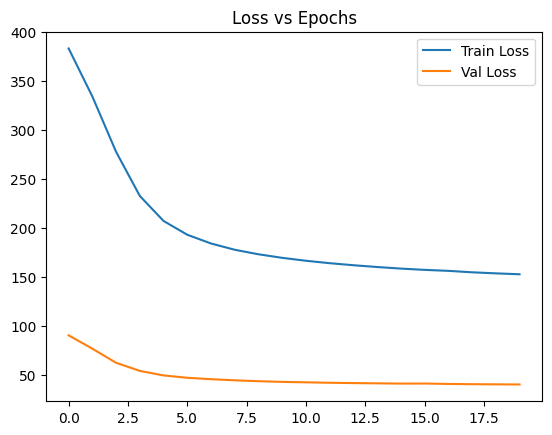

In [12]:
train(model, trainset, batch_size, seq_len, epochs, lr=lr, valid=validset)

### 模型预测

In [19]:
def predict(model, char, top_k = None, hidden_size = None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()
    with torch.no_grad():
        char = np.array([char]) # 转换为array
        char = char.reshape(-1, 1) # shape转换
        char_encoding = model.onehot_encode(char) # encoding
        char_encoding = char_encoding.reshape(1, 1, -1) # (batch_size, seq_len, num_features)
        char_tensor = torch.tensor(char_encoding, dtype=torch.float32) # 类型转换
        char_tensor = char_tensor.to(device) # 部署到device上
        
        out, hidden_size = model(char_tensor, hidden_size) # 模型预测
        
        probs = F.softmax(out, dim=1).squeeze() 
        
        if top_k is None:
            indices = np.arange(vocab_size)
        else:
            probs, indices = probs.topk(top_k) # 选取概率最大的前top_k个
            indices = indices.cpu().numpy()
            
        probs = probs.cpu().numpy()
        
        char_index = np.random.choice(indices, p = probs / probs.sum()) # 随机选取一个索引
        char = model.int_char[char_index] # 获取索引对应的字符
        
    return char, hidden_size

In [20]:
# 选取一个样本
def sample(model, length, top_k = None, sentence="every unhappy family"):
    hidden_size = None # 初始化
    new_sentence = [char for char in sentence] # 初始化
    for i in range(length):
        next_char, hidden_size = predict(model, new_sentence[-1], top_k = top_k, hidden_size = hidden_size) # 预测下一个字符
        new_sentence.append(next_char)
        
    return ''.join(new_sentence)

In [21]:
new_text = sample(model, 2000, top_k=5)

In [24]:
new_text

'every unhappy family its of an agreeable tone. It\'s no distress this work, and at all they had chiler, but that has come to spick\nthe\nrecape. Although she divusing a\nladge of his hoot to him.\n\n"You do you could not tell your orest to her, and, I wanted to speak\nthat," said Kitty. "Allow teach to the coachion.... The same!"\n\n"It\'s always so\nmy leaving the solitan is\nsuch a conversation. That\'s the mullinated thing of\nit. And the matter\nthe triving conversations, that you could never take its in\nthrough here......."\n\n"What a crused you\'ve never seen me?" he said, smiled and turning at the might seeked it on, so as to his head of the corner were\nstarming on\nhis face without his sour and\nsuch\nas she were to say to the children in spite of his\nside.\n\n"You do nothing," said Kitty, smiling\nin the steps and walking up to him and the country of the same three, and that she said:\n\n"I am too likely on the seconds of this study, and she decided me.\nBut too wondering 

### 保存模型

In [23]:
model_name = "lstm_model.net"

checkpoint = {
    'hidden_size' : model.hidden_size,
    'num_layers' : model.num_layers,
    'state_dict' : model.state_dict()
}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)